# Quantization Aware Training with NNCF, using TensorFlow Framework

The goal of this notebook to demonstrate how to use the Neural Network Compression Framework [NNCF](https://github.com/openvinotoolkit/nncf) 8-bit quantization to optimize a TensorFlow model for inference with OpenVINO™ Toolkit. The optimization process contains the following steps:

* Transforming the original `FP32` model to `INT8`
* Using fine-tuning to restore the accuracy.
* Exporting optimized and original models to Frozen Graph and then to OpenVINO.
* Measuring and comparing the performance of models.

For more advanced usage, refer to these [examples](https://github.com/openvinotoolkit/nncf/tree/develop/examples).

This tutorial uses the ResNet-18 model with Imagenette dataset. Imagenette is a subset of 10 easily classified classes from the ImageNet dataset. Using the smaller model and dataset will speed up training and download time.


#### Table of contents:
- [Imports and Settings](#Imports-and-Settings)
- [Dataset Preprocessing](#Dataset-Preprocessing)
- [Define a Floating-Point Model](#Define-a-Floating-Point-Model)
- [Pre-train a Floating-Point Model](#Pre-train-a-Floating-Point-Model)
- [Create and Initialize Quantization](#Create-and-Initialize-Quantization)
- [Fine-tune the Compressed Model](#Fine-tune-the-Compressed-Model)
- [Export Models to OpenVINO Intermediate Representation (IR)](#Export-Models-to-OpenVINO-Intermediate-Representation-(IR))
- [Benchmark Model Performance by Computing Inference Time](#Benchmark-Model-Performance-by-Computing-Inference-Time)


## Imports and Settings
[back to top ⬆️](#Table-of-contents:)

Import NNCF and all auxiliary packages from your Python code.
Set a name for the model, input image size, used batch size, and the learning rate. Also, define paths where Frozen Graph and OpenVINO IR versions of the models will be stored.

> **NOTE**: All NNCF logging messages below ERROR level (INFO and WARNING) are disabled to simplify the tutorial. For production use, it is recommended to enable logging by removing ```set_log_level(logging.ERROR)```.

In [ ]:
import sys
import importlib.util

%pip install -q "openvino>=2023.1.0" "nncf>=2.5.0"
if sys.platform == "win32":
    if importlib.util.find_spec("tensorflow_datasets"):
        %pip uninstall -q tensorflow-datasets
    %pip install -q --upgrade "tfds-nightly"
else:
    %pip install -q "tensorflow-datasets>=4.8.0"

In [2]:
from pathlib import Path
import logging

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras import models

from nncf import NNCFConfig
from nncf.tensorflow.helpers.model_creation import create_compressed_model
from nncf.tensorflow.initialization import register_default_init_args
from nncf.common.logging.logger import set_log_level
import openvino as ov

set_log_level(logging.ERROR)

MODEL_DIR = Path("model")
OUTPUT_DIR = Path("output")
MODEL_DIR.mkdir(exist_ok=True)
OUTPUT_DIR.mkdir(exist_ok=True)

BASE_MODEL_NAME = "ResNet-18"

fp32_h5_path = Path(MODEL_DIR / (BASE_MODEL_NAME + "_fp32")).with_suffix(".h5")
fp32_ir_path = Path(OUTPUT_DIR / "saved_model").with_suffix(".xml")
int8_pb_path = Path(OUTPUT_DIR / (BASE_MODEL_NAME + "_int8")).with_suffix(".pb")
int8_ir_path = int8_pb_path.with_suffix(".xml")

BATCH_SIZE = 128
IMG_SIZE = (64, 64)  # Default Imagenet image size
NUM_CLASSES = 10  # For Imagenette dataset

LR = 1e-5

MEAN_RGB = (0.485 * 255, 0.456 * 255, 0.406 * 255)  # From Imagenet dataset
STDDEV_RGB = (0.229 * 255, 0.224 * 255, 0.225 * 255)  # From Imagenet dataset

fp32_pth_url = "https://storage.openvinotoolkit.org/repositories/nncf/openvino_notebook_ckpts/305_resnet18_imagenette_fp32_v1.h5"
_ = tf.keras.utils.get_file(fp32_h5_path.resolve(), fp32_pth_url)
print(f'Absolute path where the model weights are saved:\n {fp32_h5_path.resolve()}')

2023-10-24 11:23:22.487781: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-24 11:23:22.528197: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-24 11:23:23.291918: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino
134604992/134604992 [==============================] - 7s 0us/step
Absolute path where the model weights are saved:
 /home/ea/work/openvino_notebooks/notebooks/305-tensorflow-quantization-aware-training/model/ResNet-18_fp32.h5


## Dataset Preprocessing
[back to top ⬆️](#Table-of-contents:)

Download and prepare Imagenette 160px dataset.
- Number of classes: 10
- Download size: 94.18 MiB

    | Split        | Examples |
    |--------------|----------|
    | 'train'      | 12,894   |
    | 'validation' | 500      |

2023-10-24 11:23:33.380719: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-10-24 11:23:33.507348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-10-24 11:23:33.507807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Pla

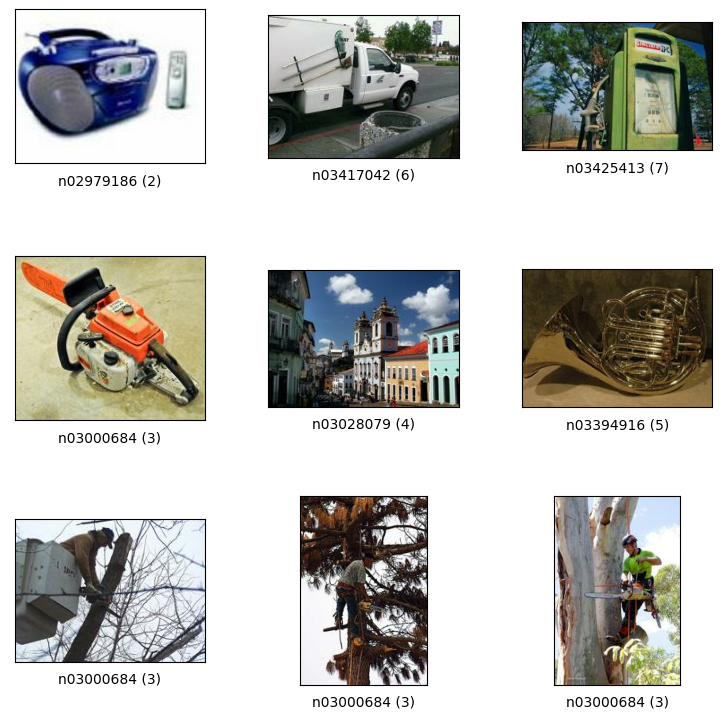

In [3]:
datasets, datasets_info = tfds.load('imagenette/160px', shuffle_files=True, as_supervised=True, with_info=True,
                                    read_config=tfds.ReadConfig(shuffle_seed=0))
train_dataset, validation_dataset = datasets['train'], datasets['validation']
fig = tfds.show_examples(train_dataset, datasets_info)

In [4]:
def preprocessing(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = image - MEAN_RGB
    image = image / STDDEV_RGB
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


train_dataset = (train_dataset.map(preprocessing, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                              .batch(BATCH_SIZE)
                              .prefetch(tf.data.experimental.AUTOTUNE))

validation_dataset = (validation_dataset.map(preprocessing, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                                        .batch(BATCH_SIZE)
                                        .prefetch(tf.data.experimental.AUTOTUNE))

## Define a Floating-Point Model
[back to top ⬆️](#Table-of-contents:)


In [5]:
def residual_conv_block(filters, stage, block, strides=(1, 1), cut='pre'):
    def layer(input_tensor):
        x = layers.BatchNormalization(epsilon=2e-5)(input_tensor)
        x = layers.Activation('relu')(x)

        # Defining shortcut connection.
        if cut == 'pre':
            shortcut = input_tensor
        elif cut == 'post':
            shortcut = layers.Conv2D(filters, (1, 1), strides=strides, kernel_initializer='he_uniform', 
                                     use_bias=False)(x)

        # Continue with convolution layers.
        x = layers.ZeroPadding2D(padding=(1, 1))(x)
        x = layers.Conv2D(filters, (3, 3), strides=strides, kernel_initializer='he_uniform', use_bias=False)(x)

        x = layers.BatchNormalization(epsilon=2e-5)(x)
        x = layers.Activation('relu')(x)
        x = layers.ZeroPadding2D(padding=(1, 1))(x)
        x = layers.Conv2D(filters, (3, 3), kernel_initializer='he_uniform', use_bias=False)(x)

        # Add residual connection.
        x = layers.Add()([x, shortcut])
        return x

    return layer


def ResNet18(input_shape=None):
    """Instantiates the ResNet18 architecture."""
    img_input = layers.Input(shape=input_shape, name='data')

    # ResNet18 bottom
    x = layers.BatchNormalization(epsilon=2e-5, scale=False)(img_input)
    x = layers.ZeroPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer='he_uniform', use_bias=False)(x)
    x = layers.BatchNormalization(epsilon=2e-5)(x)
    x = layers.Activation('relu')(x)
    x = layers.ZeroPadding2D(padding=(1, 1))(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(x)

    # ResNet18 body
    repetitions = (2, 2, 2, 2)
    for stage, rep in enumerate(repetitions):
        for block in range(rep):
            filters = 64 * (2 ** stage)
            if block == 0 and stage == 0:
                x = residual_conv_block(filters, stage, block, strides=(1, 1), cut='post')(x)
            elif block == 0:
                x = residual_conv_block(filters, stage, block, strides=(2, 2), cut='post')(x)
            else:
                x = residual_conv_block(filters, stage, block, strides=(1, 1), cut='pre')(x)
    x = layers.BatchNormalization(epsilon=2e-5)(x)
    x = layers.Activation('relu')(x)

    # ResNet18 top
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(NUM_CLASSES)(x)
    x = layers.Activation('softmax')(x)

    # Create the model.
    model = models.Model(img_input, x)

    return model

In [6]:
IMG_SHAPE = IMG_SIZE + (3,)
fp32_model = ResNet18(input_shape=IMG_SHAPE)

## Pre-train a Floating-Point Model
[back to top ⬆️](#Table-of-contents:)

Using NNCF for model compression assumes that the user has a pre-trained model and a training pipeline.

> **NOTE** For the sake of simplicity of the tutorial, it is recommended to skip `FP32` model training and load the weights that are provided.

In [7]:
# Load the floating-point weights.
fp32_model.load_weights(fp32_h5_path)

# Compile the floating-point model.
fp32_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc@1')]
)

# Validate the floating-point model.
test_loss, acc_fp32 = fp32_model.evaluate(
    validation_dataset,
    callbacks=tf.keras.callbacks.ProgbarLogger(stateful_metrics=['acc@1'])
)
print(f"\nAccuracy of FP32 model: {acc_fp32:.3f}")

2023-10-24 11:23:34.691569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-10-24 11:23:34.691989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 1s 180ms/sample - loss: 0.9807 - acc@1: 0.8220

Accuracy of FP32 model: 0.822


## Create and Initialize Quantization
[back to top ⬆️](#Table-of-contents:)

NNCF enables compression-aware training by integrating into regular training pipelines. The framework is designed so that modifications to your original training code are minor. Quantization is the simplest scenario and requires only 3 modifications.

1. Configure NNCF parameters to specify compression

In [8]:
nncf_config_dict = {
    "input_info": {"sample_size": [1, 3] + list(IMG_SIZE)},
    "log_dir": str(OUTPUT_DIR),  # The log directory for NNCF-specific logging outputs.
    "compression": {
        "algorithm": "quantization",  # Specify the algorithm here.
    },
}
nncf_config = NNCFConfig.from_dict(nncf_config_dict)

2. Provide a data loader to initialize the values of quantization ranges and determine which activation should be signed or unsigned from the collected statistics, using a given number of samples.

In [9]:
nncf_config = register_default_init_args(nncf_config=nncf_config,
                                         data_loader=train_dataset,
                                         batch_size=BATCH_SIZE)

3. Create a wrapped model ready for compression fine-tuning from a pre-trained `FP32` model and a configuration object.

In [10]:
compression_ctrl, int8_model = create_compressed_model(fp32_model, nncf_config)

2023-10-24 11:23:37.197826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-10-24 11:23:37.198214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-10-24 11:23:37.957296: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline s

Evaluate the new model on the validation set after initialization of quantization. The accuracy should be not far from the accuracy of the floating-point `FP32` model for a simple case like the one being demonstrated here.

In [11]:
# Compile the INT8 model.
int8_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc@1')]
)

# Validate the INT8 model.
test_loss, test_acc = int8_model.evaluate(
    validation_dataset,
    callbacks=tf.keras.callbacks.ProgbarLogger(stateful_metrics=['acc@1'])
)

4/4 [==============================] - 1s 339ms/sample - loss: 0.9779 - acc@1: 0.8080


## Fine-tune the Compressed Model
[back to top ⬆️](#Table-of-contents:)

At this step, a regular fine-tuning process is applied to further improve quantized model accuracy. Normally, several epochs of tuning are required with a small learning rate, the same that is usually used at the end of the training of the original model. No other changes in the training pipeline are required. Here is a simple example.

In [12]:
print(f"\nAccuracy of INT8 model after initialization: {test_acc:.3f}")

# Train the INT8 model.
int8_model.fit(train_dataset, epochs=2)

# Validate the INT8 model.
test_loss, acc_int8 = int8_model.evaluate(
    validation_dataset, callbacks=tf.keras.callbacks.ProgbarLogger(stateful_metrics=['acc@1']))
print(f"\nAccuracy of INT8 model after fine-tuning: {acc_int8:.3f}")
print(
    f"\nAccuracy drop of tuned INT8 model over pre-trained FP32 model: {acc_fp32 - acc_int8:.3f}")


Accuracy of INT8 model after initialization: 0.808
Epoch 1/2
101/101 [==============================] - 39s 316ms/step - loss: 0.7140 - acc@1: 0.9287
Epoch 2/2
4/4 [==============================] - 0s 83ms/sample - loss: 0.9788 - acc@1: 0.8160

Accuracy of INT8 model after fine-tuning: 0.816

Accuracy drop of tuned INT8 model over pre-trained FP32 model: 0.006


## Export Models to OpenVINO Intermediate Representation (IR)
[back to top ⬆️](#Table-of-contents:)

Use model conversion Python API to convert the models to OpenVINO IR.

For more information about model conversion, see this [page](https://docs.openvino.ai/2023.3/openvino_docs_model_processing_introduction.html).

Executing this command may take a while.

In [15]:
model_ir_fp32 = ov.convert_model(fp32_model)

In [17]:
model_ir_int8 = ov.convert_model(int8_model)

## Benchmark Model Performance by Computing Inference Time
[back to top ⬆️](#Table-of-contents:)

Finally, measure the inference performance of the `FP32` and `INT8` models, using [Benchmark Tool](https://docs.openvino.ai/2023.3/openvino_sample_benchmark_tool.html) - an inference performance measurement tool in OpenVINO. By default, Benchmark Tool runs inference for 60 seconds in asynchronous mode on CPU. It returns inference speed as latency (milliseconds per image) and throughput (frames per second) values.

> **NOTE**: This notebook runs `benchmark_app` for 15 seconds to give a quick indication of performance. For more accurate performance, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications. Run `benchmark_app -m model.xml -d CPU` to benchmark async inference on CPU for one minute. Change CPU to GPU to benchmark on GPU. Run `benchmark_app --help` to see an overview of all command-line options.

In [21]:
ov.save_model(model_ir_fp32, fp32_ir_path, compress_to_fp16=False)
ov.save_model(model_ir_int8, int8_ir_path, compress_to_fp16=False)


def parse_benchmark_output(benchmark_output):
    parsed_output = [line for line in benchmark_output if 'FPS' in line]
    print(*parsed_output, sep='\n')


print('Benchmark FP32 model (IR)')
benchmark_output = ! benchmark_app -m $fp32_ir_path -d CPU -api async -t 15 -shape [1,64,64,3]
parse_benchmark_output(benchmark_output)

print('\nBenchmark INT8 model (IR)')
benchmark_output = ! benchmark_app -m $int8_ir_path -d CPU -api async -t 15 -shape [1,64,64,3]
parse_benchmark_output(benchmark_output)

Benchmark FP32 model (IR)
[ INFO ] Throughput:   3223.58 FPS

Benchmark INT8 model (IR)
[ INFO ] Throughput:   13379.89 FPS


Show CPU Information for reference.

In [23]:
core = ov.Core()
core.get_property('CPU', "FULL_DEVICE_NAME")

'Intel(R) Core(TM) i9-10980XE CPU @ 3.00GHz'